<a href="https://colab.research.google.com/github/MaxSMCON/Group07/blob/main/Dimensionality_reduction_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2022-3-11

# Install prerequisites

## TSNE for GPU

In [ ]:
!nvidia-smi

Sat Mar 12 15:22:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# download and unpack tsnecuda from anaconda.org
!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.7/dist-packages/
# create a symbolic link between the downloaded libfaiss.so file and the location python's looking at
!echo $LD_LIBRARY_PATH 
# this is probably /usr/lib64-nvidia
!ln -s /content/lib/libfaiss.so $LD_LIBRARY_PATH/libfaiss.so

--2022-03-12 16:03:36--  https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5c18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5d019c23c7424a015486440c/5d790a95778a870c42137059?response-content-disposition=attachment%3B%20filename%3D%22tsnecuda-2.1.0-cuda100.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27tsnecuda-2.1.0-cuda100.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20220312T160336Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjELf%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJIMEYCIQC4tDFTx6LqsM70B0N0NXt3i%2FRAl36OGcHs0Tp34h90eQIhAOAzdgH%2FdTBxWBFawvgrmi2u3vI1Tw9DvY6VN0V4ITj%2FKvoDCC8QABoMNDU1ODY0MDk4Mzc4IgxXymgh%2BQgBnvsW3Qgq1wPXUcYSEQM

In [ ]:
import tsnecuda
tsnecuda.test()

## MDS for GPU

In [ ]:
!pip install mdscuda

     |████████████████████████████████| 38.1 MB 16.0 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from mdscuda import MDS, mds_fit, minkowski_pairs

# Global functions

In [ ]:
import pandas as pd
from scipy import stats
import numpy as np
from IPython.display import display
from tqdm.notebook import tqdm
tqdm.pandas()
import re, os
from datetime import datetime
import joblib
from functools import partial
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed

# import tensorflow as tf
# print(f"tf.__version__: {tf.__version__}")

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

import plotly.express as px
import plotly.graph_objects as go
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot') #available styles: https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
import seaborn as sns

variables = locals()

# Example: cross-sectional data

## Download data

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1g3PYZenXmftTMmBaLOcBkbU9cydaSq4a', dest_path='./train.csv.zip', unzip=True, showsize=True)
# gdd.download_file_from_google_drive(file_id='1YdeQ8sxXlZ2cuT-v-6Og10n-qMsz1_4w', dest_path='./test.csv.zip', unzip=True, showsize=True)

6.9 MiB Done.
Unzipping...Done.


## Load data

In [ ]:
%%time
df_train = pd.read_csv("train.csv", index_col=0)
# df_test = pd.read_csv("test.csv", index_col=0)
TARGET="target"
columns_predictors = [col for col in df_train.columns if col not in [TARGET]]
# print(columns_predictors)
display(df_train)

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
ID,,,,,,,,,,,,,,,,,,,,,
000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,2200000.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,2000000.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff85154c8,1065000.0,0.0,0,0.0,0,0,0,0,0,70000.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
ffb6b3f4f,48000.0,0.0,0,0.0,0,0,0,0,0,375000.0,...,0.0,0.0,80000.0,0,0,0,0,0,0,0
ffcf61eb6,2800000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


CPU times: user 2.99 s, sys: 399 ms, total: 3.39 s
Wall time: 3.66 s


## Prepare data

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_train[columns_predictors])
display(X_scaled.shape)
X_scaled

(4459, 4991)

array([[-0.03764565, -0.02163947, -0.04688961, ..., -0.07234203,
        -0.05636327, -0.12585201],
       [-0.03764565, -0.02163947, -0.04688961, ..., -0.07234203,
        -0.05636327, -0.12585201],
       [-0.03764565, -0.02163947, -0.04688961, ..., -0.07234203,
        -0.05636327, -0.12585201],
       ...,
       [-0.03764565, -0.02163947, -0.04688961, ..., -0.07234203,
        -0.05636327, -0.12585201],
       [-0.03764565, -0.02163947, -0.04688961, ..., -0.07234203,
        -0.05636327, -0.12585201],
       [-0.03764565, -0.02163947, -0.04688961, ..., -0.07234203,
        -0.05636327, -0.12585201]])

## Dimensionality reduction

### PCA

In [ ]:
%%time
from sklearn.decomposition import PCA

reducer = PCA(n_components=2)
X_reduced = reducer.fit_transform(X_scaled)
display(X_reduced.shape)
display(X_reduced)
fig = px.scatter(x=X_reduced[:,0], y=X_reduced[:,1], color=df_train[TARGET], title="PCA")
fig.update_layout(coloraxis_colorbar=dict(title=TARGET), height=1000)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()

(4459, 2)

array([[-3.34425767,  1.33573247],
       [-3.51430512,  0.55852468],
       [-4.77426123,  0.50276295],
       ...,
       [ 0.71404956,  4.24261405],
       [-4.71009003,  0.62633212],
       [ 0.12536439,  2.14391654]])

CPU times: user 3.29 s, sys: 1.42 s, total: 4.71 s
Wall time: 5.11 s


In [ ]:
%%time
from sklearn.decomposition import PCA

reducer = PCA(n_components=3)
X_reduced = reducer.fit_transform(X_scaled)
display(X_reduced.shape)
display(X_reduced)
fig = px.scatter_3d(x=X_reduced[:,0], y=X_reduced[:,1], z=X_reduced[:,2], color=df_train[TARGET], title="PCA")
fig.update_layout(coloraxis_colorbar=dict(title=TARGET), height=1000)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()

(4459, 3)

array([[-3.34425804,  1.33573317, -0.36874252],
       [-3.5143058 ,  0.55852585, -0.5864431 ],
       [-4.7742612 ,  0.50276344, -0.9396541 ],
       ...,
       [ 0.7140492 ,  4.24260532,  1.3233276 ],
       [-4.71008996,  0.62633242, -0.99648273],
       [ 0.12537009,  2.14391131, -0.31909991]])

CPU times: user 3.01 s, sys: 1.26 s, total: 4.27 s
Wall time: 3.6 s


In [ ]:
reducer.explained_variance_ratio_

array([0.02392224, 0.02086339, 0.01551813])

In [ ]:
reducer.explained_variance_ratio_.sum()

0.06030375787889893

#### Cumulative explained variance

In [ ]:
from sklearn.decomposition import PCA

n_components = np.arange(31)
cumulative_explained_variance = np.zeros_like(n_components).tolist()

def calculate_pca_explained_variance(n):
  reducer = PCA(n_components=n)
  _ = reducer.fit_transform(X_scaled)
  v = reducer.explained_variance_ratio_.sum() #total explained variance
  print(f"Cumulative explained variance for n_components={n}: {v}")
  return n, v

max_workers = 4
with ThreadPoolExecutor(max_workers=max_workers) as executor:
  futures = []
  for n in n_components:
    if n > 0:
      futures.append(executor.submit(calculate_pca_explained_variance, n=n))
  for future in tqdm(as_completed(futures), total=len(futures), desc="Calculation"):
    try:
      n, v = future.result()
      # print(n, v)
      cumulative_explained_variance[n]=v
    except Exception as e:
      print(e)

df_var = pd.DataFrame({"n_components": n_components, "cumulative_explained_variance": cumulative_explained_variance})
# plt.figure(figsize=(12,8))
# sns.lineplot(data=df_var,  x="n_components", y="cumulative_explained_variance");
px.line(df_var,  x="n_components", y="cumulative_explained_variance", markers=True)

Calculation:   0%|          | 0/30 [00:00<?, ?it/s]

Cumulative explained variance for n_components=1: 0.023922239055751037
Cumulative explained variance for n_components=3: 0.060303757882026396
Cumulative explained variance for n_components=4: 0.07210464060575485
Cumulative explained variance for n_components=2: 0.04478563182895617
Cumulative explained variance for n_components=5: 0.08002479162008874
Cumulative explained variance for n_components=6: 0.08743770945762015
Cumulative explained variance for n_components=8: 0.10047982579859738
Cumulative explained variance for n_components=7: 0.09408847395208621
Cumulative explained variance for n_components=9: 0.1058921975270674
Cumulative explained variance for n_components=10: 0.11043265178293178
Cumulative explained variance for n_components=11: 0.11477445006788828
Cumulative explained variance for n_components=12: 0.11843874734020207
Cumulative explained variance for n_components=13: 0.12197716634091582
Cumulative explained variance for n_components=14: 0.12526670764977751
Cumulative exp

#### PCA by chosen explained variance

In [ ]:
%%time
from sklearn.decomposition import PCA

reducer = PCA(n_components=0.8)
X_reduced = reducer.fit_transform(X_scaled)
display(X_reduced.shape)
display(X_reduced)

(4459, 829)

array([[-3.34425759e+00,  1.33573265e+00, -3.68745498e-01, ...,
        -9.54989555e-02,  4.52500309e-01,  1.63827992e-01],
       [-3.51430516e+00,  5.58524601e-01, -5.86445688e-01, ...,
        -3.12614445e-01, -2.63379643e-01, -1.00461617e-01],
       [-4.77426124e+00,  5.02762328e-01, -9.39665349e-01, ...,
         2.14907376e-02, -3.26970446e-03,  1.09001632e-01],
       ...,
       [ 7.14049468e-01,  4.24261041e+00,  1.32336431e+00, ...,
        -1.37965534e+00, -6.96799192e-01,  7.93203747e-01],
       [-4.71009004e+00,  6.26331549e-01, -9.96492036e-01, ...,
         8.66752412e-02,  3.28057005e-02,  3.02540851e-02],
       [ 1.25369041e-01,  2.14392601e+00, -3.19030960e-01, ...,
        -3.18076024e-01,  4.37498311e-01,  2.96861201e-01]])

CPU times: user 2min 11s, sys: 6.65 s, total: 2min 17s
Wall time: 1min 14s


### Incremental PCA

In [ ]:
%%time
from sklearn.decomposition import IncrementalPCA

reducer = IncrementalPCA(n_components=2)
X_reduced = reducer.fit_transform(X_scaled)
display(X_reduced.shape)
display(X_reduced)
fig = px.scatter(x=X_reduced[:,0], y=X_reduced[:,1], color=df_train[TARGET], title="Incremental PCA")
fig.update_layout(coloraxis_colorbar=dict(title=TARGET), height=1000)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()

(4459, 2)

array([[-3.34425759,  1.33573265],
       [-3.51430516,  0.5585246 ],
       [-4.77426124,  0.50276233],
       ...,
       [ 0.71404947,  4.24261041],
       [-4.71009004,  0.62633155],
       [ 0.12536904,  2.14392601]])

CPU times: user 2min 7s, sys: 10.1 s, total: 2min 17s
Wall time: 1min 24s


### Kernel PCA

In [ ]:
%%time
from sklearn.decomposition import KernelPCA

reducer = KernelPCA(n_components=2, kernel='poly', n_jobs=-1)
X_reduced = reducer.fit_transform(X_scaled)
display(X_reduced.shape)
display(X_reduced)
fig = px.scatter(x=X_reduced[:,0], y=X_reduced[:,1], color=df_train[TARGET], title="Kernel PCA")
fig.update_layout(coloraxis_colorbar=dict(title=TARGET), height=1000)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()

(4459, 2)

array([[-0.04814609, -0.02126624],
       [-0.04671148, -0.02159578],
       [-0.048947  , -0.02227436],
       ...,
       [-0.04058533, -0.00944949],
       [-0.0489523 , -0.02219656],
       [-0.04931255, -0.01872417]])

CPU times: user 14.9 s, sys: 2.02 s, total: 16.9 s
Wall time: 11.1 s


In [ ]:
%%time
from sklearn.decomposition import KernelPCA

reducer = KernelPCA(n_components=2, kernel='rbf', n_jobs=-1)
X_reduced = reducer.fit_transform(X_scaled)
display(X_reduced.shape)
display(X_reduced)
fig = px.scatter(x=X_reduced[:,0], y=X_reduced[:,1], color=df_train[TARGET], title="kPCA")
fig.update_layout(coloraxis_colorbar=dict(title=TARGET), height=1000)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()

(4459, 2)

array([[-0.26128237,  0.02994038],
       [-0.15193227, -0.00781127],
       [-0.35747119, -0.00962109],
       ...,
       [ 0.60392291, -0.01532981],
       [-0.35804806, -0.01136083],
       [ 0.56668596, -0.00891096]])

CPU times: user 11.3 s, sys: 1.28 s, total: 12.6 s
Wall time: 7.84 s


In [ ]:
%%time
from sklearn.decomposition import KernelPCA

reducer = KernelPCA(n_components=3, kernel='rbf', n_jobs=-1)
X_reduced = reducer.fit_transform(X_scaled)
display(X_reduced.shape)
display(X_reduced)
fig = px.scatter_3d(x=X_reduced[:,0], y=X_reduced[:,1], z=X_reduced[:,2], color=df_train[TARGET], title="kPCA")
fig.update_layout(coloraxis_colorbar=dict(title=TARGET), height=1000)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()

(4459, 3)

array([[-0.26128237,  0.02994038,  0.00065943],
       [-0.15193227, -0.00781127, -0.00095187],
       [-0.35747119, -0.00962109, -0.00988164],
       ...,
       [ 0.60392291, -0.01532981, -0.02263421],
       [-0.35804806, -0.01136083, -0.01037071],
       [ 0.56668596, -0.00891096, -0.01619895]])

CPU times: user 11.2 s, sys: 1.23 s, total: 12.5 s
Wall time: 7.6 s


### TSNE

In [ ]:
%%time
from tsnecuda import TSNE
#from sklearn.manifold import TSNE

reducer = TSNE(n_components=2)
X_reduced = reducer.fit_transform(X_scaled)
display(X_reduced.shape)
display(X_reduced)
fig = px.scatter(x=X_reduced[:,0], y=X_reduced[:,1], color=df_train[TARGET], title="TSNE")
fig.update_layout(coloraxis_colorbar=dict(title=TARGET), height=1000)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()

(4459, 2)

array([[ 1.451871 ,  0.586906 ],
       [-4.2192264, -0.9979847],
       [-2.551778 ,  2.0670583],
       ...,
       [-2.1000018,  6.4215736],
       [-2.4592047,  1.264916 ],
       [-6.0965967,  2.9710116]], dtype=float32)

CPU times: user 3.32 s, sys: 199 ms, total: 3.51 s
Wall time: 3.31 s


### MDS

In [ ]:
%%time
from mdscuda import MDS, mds_fit, minkowski_pairs
#from sklearn.manifold import MDS

# reducer = MDS(n_components=2)
# X_reduced = reducer.fit_transform(X_scaled)
X_reduced = mds_fit(minkowski_pairs(X_scaled, sqform=False), n_dims=2)
display(X_reduced.shape)
display(X_reduced)
fig = px.scatter(x=X_reduced[:,0], y=X_reduced[:,1], color=df_train[TARGET], title="MDS")
fig.update_layout(coloraxis_colorbar=dict(title=TARGET), height=1000)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()

(4459, 2)

array([[  -5.1695786 ,  -14.998944  ],
       [  -5.3931684 ,  -25.559374  ],
       [   0.12257824,   -2.0267057 ],
       ...,
       [  52.47992   , -118.43097   ],
       [  -1.3721852 ,   -1.5237339 ],
       [  25.540714  ,  109.510994  ]], dtype=float32)

CPU times: user 22.1 s, sys: 178 ms, total: 22.2 s
Wall time: 22.3 s


In [ ]:
%%time
from mdscuda import MDS, mds_fit, minkowski_pairs
#from sklearn.manifold import MDS

# reducer = MDS(n_components=3)
# X_reduced = reducer.fit_transform(X_scaled)
X_reduced = mds_fit(minkowski_pairs(X_scaled, sqform=False), n_dims=3)
display(X_reduced.shape)
display(X_reduced)
fig = px.scatter_3d(x=X_reduced[:,0], y=X_reduced[:,1], z=X_reduced[:,2], color=df_train[TARGET], title="MDS")
fig.update_layout(coloraxis_colorbar=dict(title=TARGET), height=1000)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()

(4459, 3)

array([[ 7.7507987e+00, -1.2422090e+01,  1.0146767e+01],
       [-8.0696151e-02, -1.7641365e+01, -2.3179340e+01],
       [-2.0448000e+00,  3.5871938e-01, -1.4678454e+00],
       ...,
       [-1.6345314e+01,  8.2279762e+01, -9.8419273e+01],
       [ 7.8744435e-01,  7.6247531e-01, -1.9513788e+00],
       [ 6.3834888e+01, -9.4162498e+01,  5.1873317e+00]], dtype=float32)

CPU times: user 24.6 s, sys: 149 ms, total: 24.7 s
Wall time: 25.1 s


# Example: images

## Download data

(60000, 28, 28)

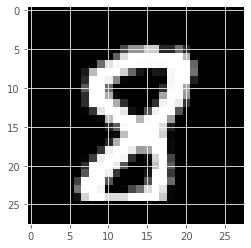

In [ ]:
from tensorflow import keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
display(X_train.shape)
plt.imshow(X_train[np.random.randint(X_train.shape[0])], cmap="gray");

## Flatten image pixels as features

In [ ]:
indices = np.random.choice(len(X_train), size=3000, replace=False)
X_sample=X_train[indices]
y_sample=y_train[indices]
display(X_sample.shape)

In [ ]:
!nvidia-smi

Sat Mar 12 16:01:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    73W / 149W |     85MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dimensionality reduction

### TSNE

In [ ]:
%%time
from tsnecuda import TSNE
#from sklearn.manifold import TSNE

reducer = TSNE(n_components=2)
X_reduced = reducer.fit_transform(X_sample)
display(X_reduced.shape)
display(X_reduced)
fig = px.scatter(x=X_reduced[:,0], y=X_reduced[:,1], color=df_train[TARGET], title="TSNE")
fig.update_layout(coloraxis_colorbar=dict(title=TARGET), height=1000)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



ValueError: ignored

### MDS

In [ ]:
%%time
from mdscuda import MDS, mds_fit, minkowski_pairs
#from sklearn.manifold import MDS

# reducer = MDS(n_components=2)
# X_reduced = reducer.fit_transform(X_sample)
X_reduced = mds_fit(minkowski_pairs(X_sample, sqform=False), n_dims=2)
display(X_reduced.shape)
display(X_reduced)
fig = px.scatter(x=X_reduced[:,0], y=X_reduced[:,1], color=df_train[TARGET], title="MDS")
fig.update_layout(coloraxis_colorbar=dict(title=TARGET), height=1000)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()

CudaAPIError: ignored